In [228]:
#!pip install sweetviz
#!pip install pandas-profiling
#!pip install imbalanced-learn

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px
from datetime import datetime
import time
import matplotlib.cm as cm

# Importamos algunas librerías para análisis de datos
import sweetviz as sv

from sklearn.tree import DecisionTreeClassifier
#from sklearn import cluster
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, MeanShift, AgglomerativeClustering, SpectralClustering, DBSCAN, OPTICS, Birch, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Directory and Version Specification


In [229]:
MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d__%H-%M-%S")

DATA_PATH = 'data/'

# Resolución de imágenes
resolution = 300

MODEL_TIMESTAMP

'2022-05-08__19-29-48'

# Help Functions and Parameters

> Definimos las funciones de ayuda que nos permitiran realizar un análisis de los métodos de cluster que vamos a implementar. Estas funciones son: `silhoutte_analysis` que nos permitirá hacer un análisis de silueta de los clusters generados, así podremos determinar el mejor score por número de clusters. La otra función es `elbow_method` que nos permitirá hacer una análisis visual por el método del codo para idetificar en que punto se genera el codo, este método puede ser un poco dificil de identificarl en algunos casos, por este motivo se complementa con el análisis de silueta.

In [230]:
def silhoutte_analysis(_cluster_data, model):
    num_clusters = range(2,10)
    for k in num_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(_cluster_data) + (k + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters=k, random_state=10) #KMeans(n_clusters=k, random_state=10)
        cluster_labels = clusterer.fit_predict(_cluster_data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(_cluster_data, cluster_labels)
        print("For n_clusters =", k,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(_cluster_data, cluster_labels)

        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
        ax2.scatter(np.array(_cluster_data)[:, 0], np.array(_cluster_data)[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % k),
                     fontsize=14, fontweight='bold')

    plt.show()

def elbow_method(_cluster_data, _model):
    sum_of_squared_distances = []
    num_clusters = range(1,10)

    for i in num_clusters:
        model = _model(n_clusters = i, random_state = 42)
        model.fit(_cluster_data)
        sum_of_squared_distances.append(model.inertia_)
        
    plt.figure(figsize = (10, 8))
    plt.plot(num_clusters, sum_of_squared_distances, marker = 'o', linestyle = '--')
    plt.xlabel('Valor de k (número de clusters)')
    plt.ylabel('Suma de las distancias al cuadrado')
    plt.title('Método del codo para buscar una k optima')
    plt.show()

In [231]:
# Parámetros para clustering
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 2,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

> Aquí definimos la función para tratar los datos no numéricos de nuestro dataset.

In [232]:
def handle_non_numerical_data(df):
    
    # handling non-numerical data: must convert.
    columns = df.columns.values

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        #print(column,df[column].dtype)
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            
            column_contents = df[column].values.tolist()
            #finding just the uniques
            unique_elements = set(column_contents)
            # great, found them. 
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    # creating dict that contains new
                    # id per unique string
                    text_digit_vals[unique] = x
                    x+=1
            # now we map the new "id" vlaue
            # to replace the string. 
            df[column] = list(map(convert_to_int,df[column]))

    return df

# Load Data

In [233]:
atp = pd.DataFrame()

years_index_20_22 = range(0,22)

for index in years_index_20_22:
    index_str = str(index)

    if len(index_str) == 1:
        index_str = '0' + index_str

    FILE_NAME = "atp_matches_20{}.csv".format(index_str)

    data_frame_iter = pd.read_csv(DATA_PATH + FILE_NAME)
    atp = pd.concat([atp, data_frame_iter])

# Mostramos todas las columnas, con este comando evitamos que se oculten cuando son muchas.
pd.set_option('display.max_columns', None) 
atp

tourney_id                  tourney_name surface  \
0                            2000-301                      Auckland    Hard   
1                            2000-301                      Auckland    Hard   
2                            2000-301                      Auckland    Hard   
3                            2000-301                      Auckland    Hard   
4                            2000-301                      Auckland    Hard   
...                               ...                           ...     ...   
2722  2021-M-DC-2021-WG2-M-THA-DEN-01  Davis Cup WG2 R1: THA vs DEN    Hard   
2723  2021-M-DC-2021-WG2-M-THA-DEN-01  Davis Cup WG2 R1: THA vs DEN    Hard   
2724  2021-M-DC-2021-WG2-M-TUR-LAT-01  Davis Cup WG2 R1: TUR vs LAT    Hard   
2725  2021-M-DC-2021-WG2-M-TUR-LAT-01  Davis Cup WG2 R1: TUR vs LAT    Hard   
2726  2021-M-DC-2021-WG2-M-TUR-LAT-01  Davis Cup WG2 R1: TUR vs LAT    Hard   

      draw_size tourney_level  tourney_date  match_num  winner_id  \
0            32             A      20000110          1     103163   
1            32             A      20000110          2     102607   
2            32             A      20000110          3     103252   
3            32             A      20000110          4     103507   
4            32             A      20000110          5     102103   
...         ...           ...           ...        ...        ...   
2722          4             D      20210917          4     200416   
2723          4             D      20210917          5     208937   
2724          4             D      20210918          1     123795   
2725          4             D      20210918          2     117356   
2726          4             D      20210918          4     144985   

      winner_seed winner_entry          winner_name winner_hand  winner_ht  \
0             1.0          NaN           Tommy Haas           R      188.0   
1             NaN            Q        Juan Balcells           R      190.0   
2             NaN          NaN       Alberto Martin           R      175.0   
3             7.0          NaN  Juan Carlos Ferrero           R      183.0   
4             NaN            Q         Michael Sell           R      180.0   
...           ...          ...                  ...         ...        ...   
2722          NaN          NaN      August Holmgren           R        NaN   
2723          NaN          NaN       Kasidit Samrej           R        NaN   
2724          NaN          NaN     Altug Celikbilek           U        NaN   
2725          NaN          NaN            Cem Ilkel           R      185.0   
2726          NaN          NaN          Ergi Kirkin           R        NaN   

     winner_ioc  winner_age  loser_id  loser_seed loser_entry  \
0           GER   21.771389    101543         NaN         NaN   
1           ESP   24.558522    102644         NaN         NaN   
2           ESP   21.390828    102238         NaN         NaN   
3           ESP   19.909651    103819         NaN         NaN   
4           USA   27.381246    102765         4.0         NaN   
...         ...         ...       ...         ...         ...   
2722        DEN   23.394935    106397         NaN         NaN   
2723        THA   20.629706    134087         NaN         NaN   
2724        TUR   25.015743    207669         NaN         NaN   
2725        TUR   26.064339    105208         NaN         NaN   
2726        TUR   22.628337    120270         NaN         NaN   

                       loser_name loser_hand  loser_ht loser_ioc  loser_age  \
0                    Jeff Tarango          L     180.0       USA  31.137577   
1                Franco Squillari          L     183.0       ARG  24.386037   
2             Alberto Berasategui          R     173.0       ESP  26.535250   
3                   Roger Federer          R     185.0       SUI  18.422998   
4                  Nicolas Escude          R     185.0       FRA  23.770021   
...                           ...        ...       ...   

In [234]:
print('=================================================================')
print(atp.info())
print('=================================================================')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65894 entries, 0 to 2726
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          65894 non-null  object 
 1   tourney_name        65894 non-null  object 
 2   surface             65894 non-null  object 
 3   draw_size           65894 non-null  int64  
 4   tourney_level       65894 non-null  object 
 5   tourney_date        65894 non-null  int64  
 6   match_num           65894 non-null  int64  
 7   winner_id           65894 non-null  int64  
 8   winner_seed         27355 non-null  float64
 9   winner_entry        8128 non-null   object 
 10  winner_name         65894 non-null  object 
 11  winner_hand         65885 non-null  object 
 12  winner_ht           63258 non-null  float64
 13  winner_ioc          65894 non-null  object 
 14  winner_age          65891 non-null  float64
 15  loser_id            65894 non-null  int64  
 16  loser

# Clean Dataset
> Realizamos la limpieza de algunos datos, realizamos algunas transformaciones en algunas variables categóricas.
> 

In [235]:
df_clustering = atp.copy()
round_replace = {'R128': 128,
                  'R64': 64,
                  'R32': 32,
                  'R16': 16,
                  'QF': 4,
                  'SF': 2,
                  'F': 1
}

# Eliminamos las Round Robin (RR y ER)
df_clustering['round'].replace(round_replace, inplace = True)
df_clustering

df_pca = atp.copy()
df_pca['round'].replace(round_replace, inplace = True)

In [236]:
accident_type_replace = {}
for index,accident_type in enumerate(df_clustering.tourney_name.unique()):
    if not pd.isna(accident_type): accident_type_replace[accident_type] = int(index)
    
df_clustering['tourney_name'].replace(accident_type_replace, inplace = True)
df_clustering

df_pca['tourney_name'].replace(accident_type_replace, inplace = True)
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65894 entries, 0 to 2726
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          65894 non-null  object 
 1   tourney_name        65894 non-null  int64  
 2   surface             65894 non-null  object 
 3   draw_size           65894 non-null  int64  
 4   tourney_level       65894 non-null  object 
 5   tourney_date        65894 non-null  int64  
 6   match_num           65894 non-null  int64  
 7   winner_id           65894 non-null  int64  
 8   winner_seed         27355 non-null  float64
 9   winner_entry        8128 non-null   object 
 10  winner_name         65894 non-null  object 
 11  winner_hand         65885 non-null  object 
 12  winner_ht           63258 non-null  float64
 13  winner_ioc          65894 non-null  object 
 14  winner_age          65891 non-null  float64
 15  loser_id            65894 non-null  int64  
 16  loser

In [237]:
COLUMNS_TO_GET = [
                  "surface",
                  "minutes",
                  "winner_ht", "loser_ht",
                  "w_ace", "l_ace",
                  "w_svpt", "l_svpt", # service points
                  "w_1stWon", "l_1stWon",
                  "w_2ndWon", "l_2ndWon",
                  "w_bpSaved", "l_bpSaved",
                  "w_bpFaced", "l_bpFaced",
                  "w_SvGms", "l_SvGms", # service games won
                  "winner_rank_points", "loser_rank_points",
                  "round",
                 ]
# Parámetros de los winners y losers con los que se realizan cálculos y se debe hacer drop para
# quitar la correlación entre variables.
UNNECESSARY_ATTR = ['tourney_id', 'tourney_name', 'winner_name', 'loser_name', 'winner_entry', 'winner_seed', 'loser_entry', 'loser_seed','tourney_date', 'winner_id', 'loser_id', 'score']

WL_DROP = [ 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',  'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms']

In [238]:
df_clustering = df_clustering[df_clustering['round'] != 'RR']
df_clustering = df_clustering[df_clustering['round'] != 'ER']

df_clustering = df_clustering.drop(UNNECESSARY_ATTR, axis = 1) 
df_clustering = df_clustering.dropna()
df_clustering = df_clustering.drop_duplicates()

# Crearemos dos formulas para calculos del ganador y el perdedor para evitar la correlación de estas variables, tambien haremos un drop de estas variables.
df_clustering['w_calculation'] = df_clustering['w_svpt'] + df_clustering['w_1stIn'] + df_clustering['w_1stWon'] + df_clustering['w_2ndWon'] + df_clustering['w_SvGms']
df_clustering['l_calculation'] = df_clustering['l_svpt'] + df_clustering['l_1stIn'] + df_clustering['l_1stWon'] + df_clustering['l_2ndWon'] + df_clustering['l_SvGms']
df_clustering = df_clustering.drop(WL_DROP, axis = 1)

df_clustering = handle_non_numerical_data(df_clustering)

# Eliminamos los outlier para minutes
df_clustering = df_clustering[df_clustering['minutes'] < 400]

Counter(df_clustering['surface'])

Counter({1: 29063, 0: 17431, 3: 5843, 2: 1402})

# Resampling
> Vamos a realizar un undersampling de la variable categorica a predecir **surface** vamos a reducir las muestras a la categoría minoritaria.

> Vamos a quitar unos outliers de la variable `minutes` ya que según [Logest Tennis Match Records](https://en.wikipedia.org/wiki/Longest_tennis_match_records) no hay partidos más extensos de 400 minutos. Estos outliers pueden afectar en los resultados.

In [239]:
# Podemos observar que hay un desbalanceo en las varaibles a predecir.
df_without_under_sampling = df_clustering
print(Counter(df_clustering['surface']))

Counter({1: 29063, 0: 17431, 3: 5843, 2: 1402})


In [240]:
df_clustering.head()

X = df_clustering.drop('surface', axis=1)
y = df_clustering['surface']

# Hacemos undersampling a la categoría con menor cantidad de datos.
undersample = RandomUnderSampler(sampling_strategy='not minority')

X_over, y_over = undersample.fit_resample(X, y)
print(Counter(y_over))

df_clustering = pd.concat([X_over, y_over], axis=1)

# Eliminamos los outlier para minutes, se investigó los partidos más extensos de la historia del tennis y ninguno duró mas de 
# 660 minutos según el record mundial de los partidos de tennis más largos.
df_clustering = df_clustering[df_clustering['minutes'] < 400]

print(df_clustering.head())

Counter({0: 1402, 1: 1402, 2: 1402, 3: 1402})
   draw_size  tourney_level  match_num  winner_hand  winner_ht  winner_ioc  \
0        128              2        128            0      188.0           9   
1         28              1         26            1      190.0          45   
2         32              1         28            1      180.0           9   
3        128              2         18            1      185.0          62   
4         56              3         36            1      175.0           9   

   winner_age  loser_hand  loser_ht  loser_ioc  loser_age  best_of  round  \
0   30.360027           2     183.0         30  30.420260        5      5   
1   26.294319           1     188.0          3  31.835729        3      2   
2   28.240931           2     183.0          3  24.216290        3      4   
3   19.945243           2     178.0         68  21.300479        5      5   
4   29.023956           1     188.0          3  29.555099        3      0   

   minutes  w_ace  w_d

In [241]:
atp_report = sv.analyze(df_clustering)
atp_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Clustering

## Principal Components Analysis **(PCA)** and KMeans

> Realizaremos un análisis de componentes principales y los graficaremos para ver si es posible ver algún patrón en los datos, esto se realizará previamente a la aplicación de técnicas de clustering.

In [242]:
# Graficaremos PCA con 3 componentes

df_clustering_pca = df_clustering.copy()
X = df_clustering_pca
y = df_clustering_pca['minutes'].copy()

pca = PCA(n_components = 3) 
components = pca.fit_transform(X, y)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, color=y, z=2,
    title=f'Varianza Total Explicada: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(height=800, width=800)
fig.show()

In [243]:
wcss = []
for i in range(1, 9):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(components)
    wcss.append(kmeans_pca.inertia_)


In [244]:
kmeans_pca = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans_pca.fit(components)

KMeans(n_clusters=2, random_state=42)

In [245]:
df_pca_kmeans = pd.concat([df_clustering_pca.reset_index(drop = True), pd.DataFrame(components)], axis = 1)
df_pca_kmeans.columns.values[-3: ] = ['Componente_1', 'Componente_2', 'Componente_3']
df_pca_kmeans['ATP_KMeans_PCA'] = kmeans_pca.labels_

In [246]:
df_pca_kmeans

draw_size  tourney_level  match_num  winner_hand  winner_ht  winner_ioc  \
0           128              2        128            0      188.0           9   
1            28              1         26            1      190.0          45   
2            32              1         28            1      180.0           9   
3           128              2         18            1      185.0          62   
4            56              3         36            1      175.0           9   
...         ...            ...        ...          ...        ...         ...   
5603         32              1         22            1      185.0          25   
5604         32              1          6            1      193.0          71   
5605         32              1        298            0      190.0          25   
5606         32              1         18            1      190.0          45   
5607         56              1         40            1      185.0          36   

      winner_age  loser_hand  loser_ht  loser_ioc  loser_age  best_of  round  \
0      30.360027           2     183.0         30  30.420260        5      5   
1      26.294319           1     188.0          3  31.835729        3      2   
2      28.240931           2     183.0          3  24.216290        3      4   
3      19.945243           2     178.0         68  21.300479        5      5   
4      29.023956           1     188.0          3  29.555099        3      0   
...          ...         ...       ...        ...        ...      ...    ...   
5603   27.200548           2     185.0          3  25.828884        3      6   
5604   21.845311           2     196.0         22  29.393566        3      0   
5605   30.841889           2     183.0         30  30.496920        3      2   
5606   24.835044           2     168.0         27  31.414100        3      6   
5607   28.835044           2     193.0         24  22.225873        3      0   

      minutes  w_ace  w_df  w_svpt  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  \
0       127.0    3.0   2.0    76.0        2.0        4.0    3.0   2.0   104.0   
1       108.0   10.0   6.0    80.0        2.0        3.0    8.0   3.0    80.0   
2        76.0    3.0   0.0    53.0        3.0        5.0    1.0   2.0    50.0   
3       112.0   12.0   1.0    79.0        3.0        4.0    3.0   4.0   108.0   
4        56.0    5.0   1.0    36.0        1.0        1.0    2.0   6.0    50.0   
...       ...    ...   ...     ...        ...        ...    ...   ...     ...   
5603     72.0    7.0   0.0    52.0        2.0        3.0    4.0   2.0    63.0   
5604    189.0   12.0   2.0   132.0        5.0        7.0   13.0   3.0   149.0   
5605    119.0    3.0   6.0    87.0        5.0        7.0    1.0   2.0    83.0   
5606     86.0   21.0   2.0    71.0        2.0        3.0    3.0   0.0    70.0   
5607    102.0   20.0   4.0    87.0        1.0        2.0   11.0   5.0    97.0   

      l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
0          12.0       18.0         36.0              1260.0        83.0   
1           4.0        7.0         57.0               817.0        29.0   
2           4.0        9.0         28.0              1145.0        63.0   
3           9.0       15.0         40.0               835.0        91.0   
4           5.0       10.0          6.0              4600.0        43.0   
...         ...        ...          ...                 ...         ...   
5603        3.0        7.0         71.0               685.0        56.0   
5604       12.0       14.0         48.0               788.0        93.0   
5605        8.0       11.0         67.0               855.0        90.0   
5606        1.0        3.0        112.0               481.0        68.0   
5607        3.0        6.0          4.0              3106.0       157.0   

      loser_rank_points  w_calculation  l_calculation  surface  Componente_1  \
0                 694.0          189.0          229.0        0   -300.327613   
1                1325.0          192.0

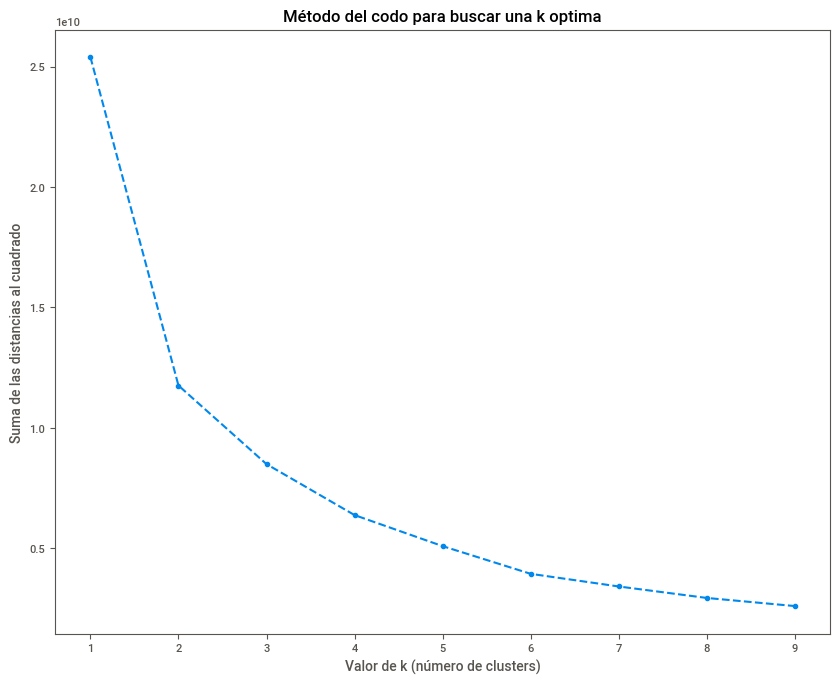

In [247]:
Componente_1 = df_pca_kmeans.Componente_1.to_list()
Componente_2 = df_pca_kmeans.Componente_2.to_list()
Componente_3 = df_pca_kmeans.Componente_3.to_list()
cluster_data = list(zip(Componente_1, Componente_2 , Componente_3))

elbow_method(cluster_data, KMeans)

### Silhoutte Analysis

[Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#:~:text=Silhouette%20analysis%20can%20be%20used,like%20number%20of%20clusters%20visually)


For n_clusters = 2 The average silhouette_score is : 0.7706225691253872
For n_clusters = 3 The average silhouette_score is : 0.6004068307885797
For n_clusters = 4 The average silhouette_score is : 0.590873006851631
For n_clusters = 5 The average silhouette_score is : 0.4815947908398065
For n_clusters = 6 The average silhouette_score is : 0.5045031514382772
For n_clusters = 7 The average silhouette_score is : 0.48056045064012537
For n_clusters = 8 The average silhouette_score is : 0.4088019100004064
For n_clusters = 9 The average silhouette_score is : 0.37378000806667466


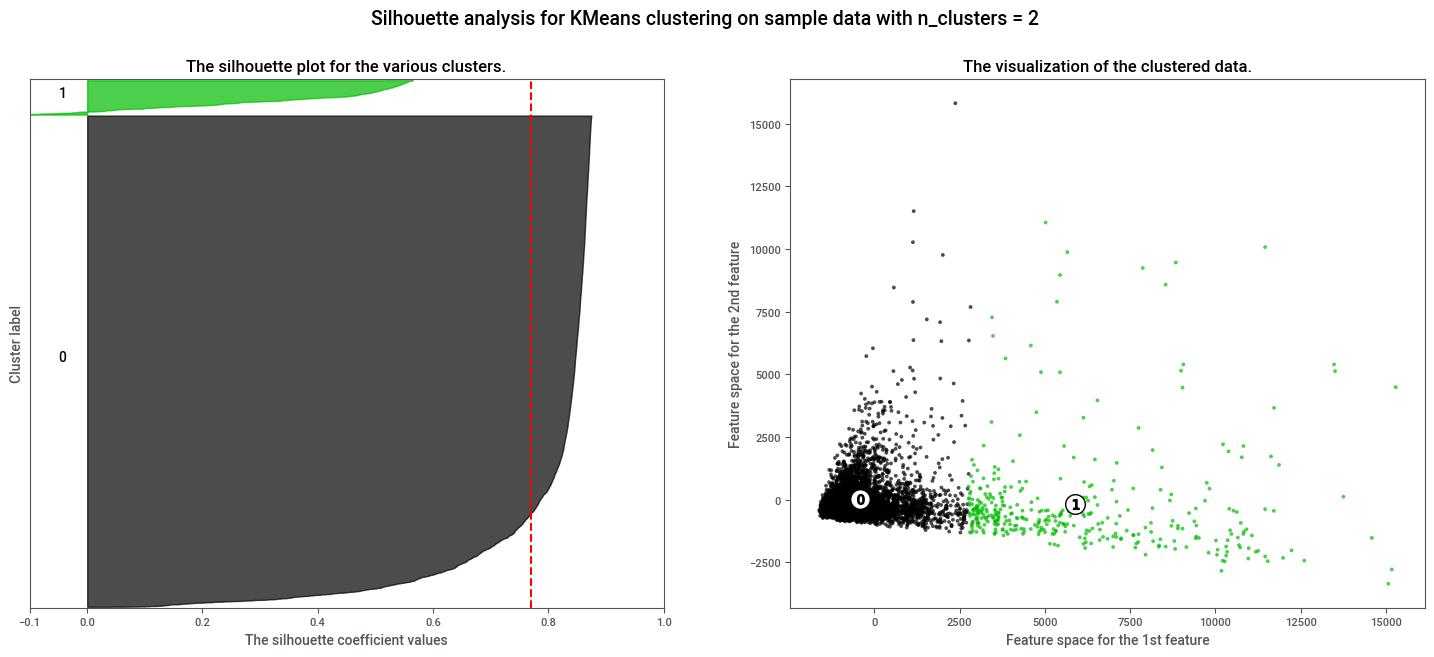

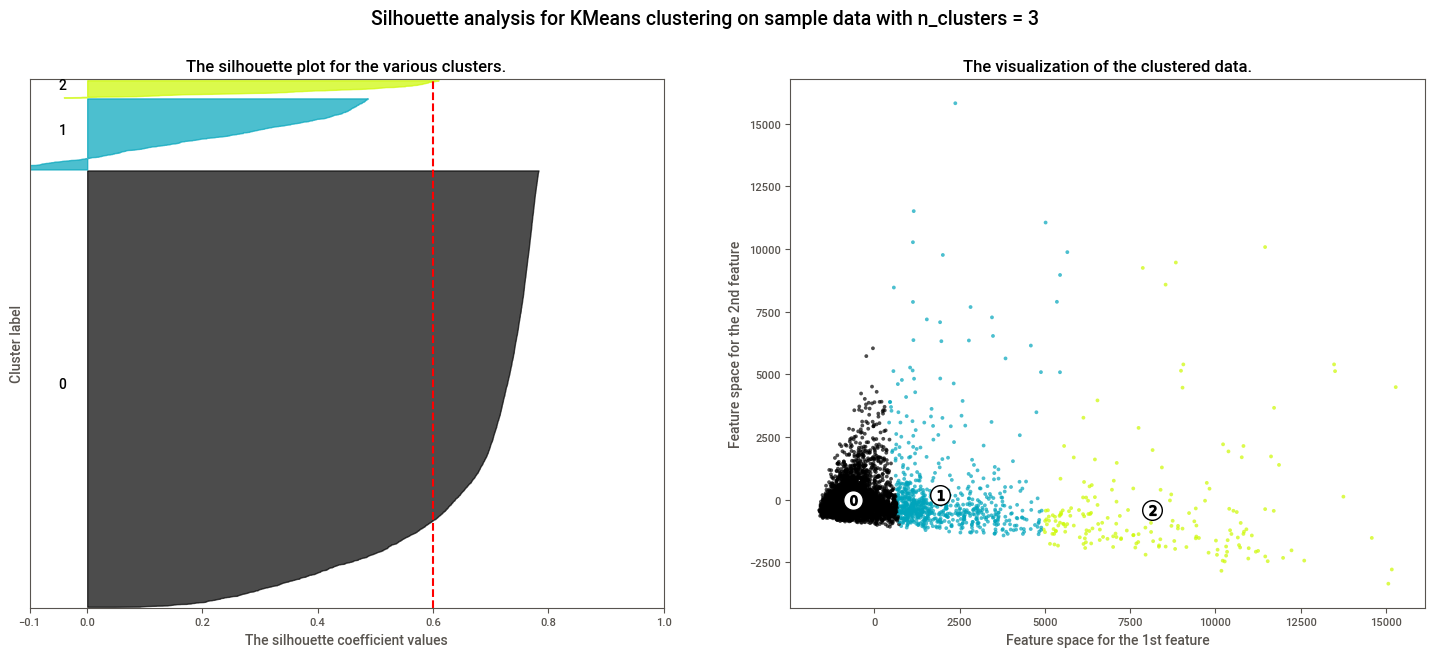

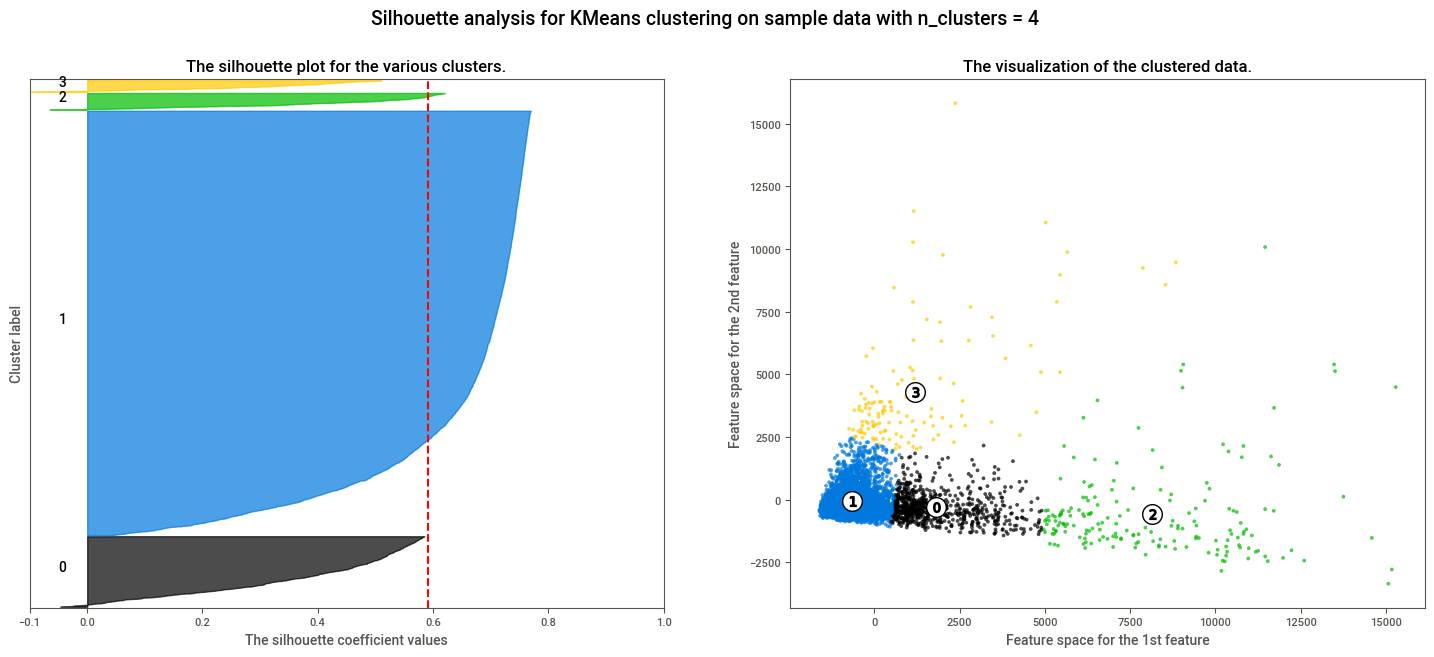

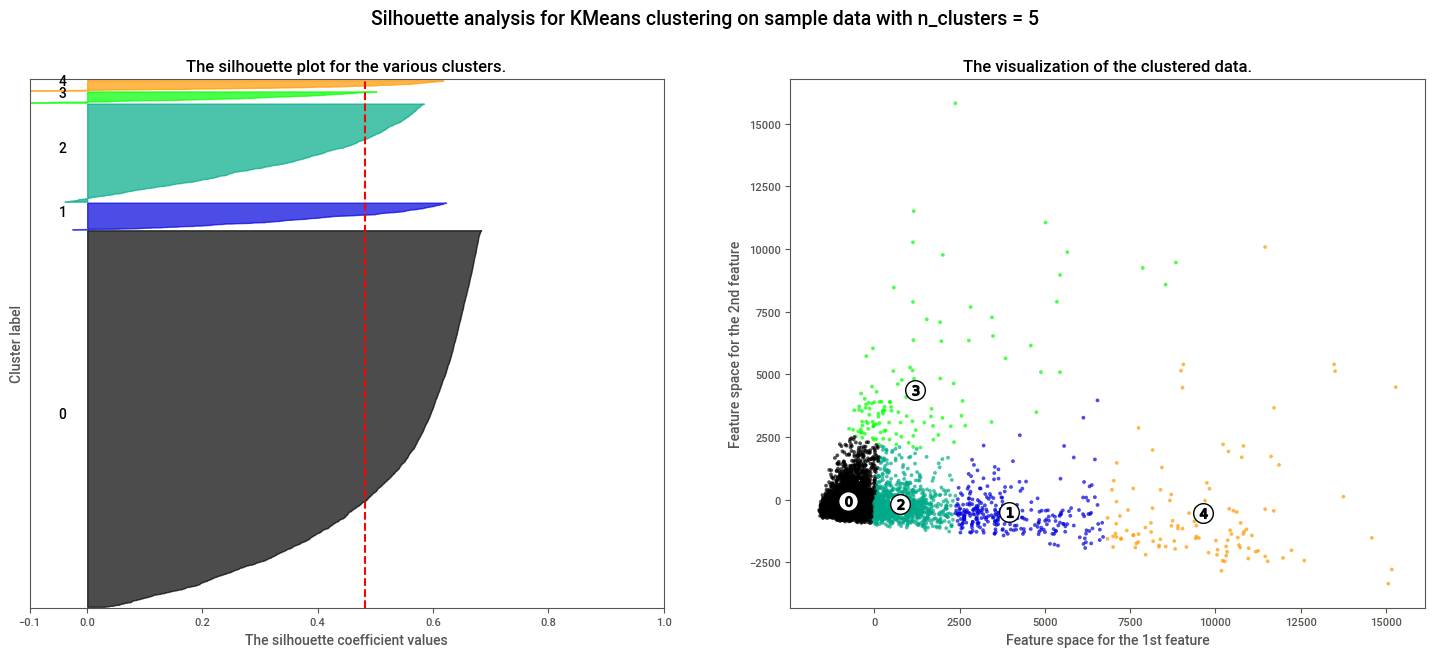

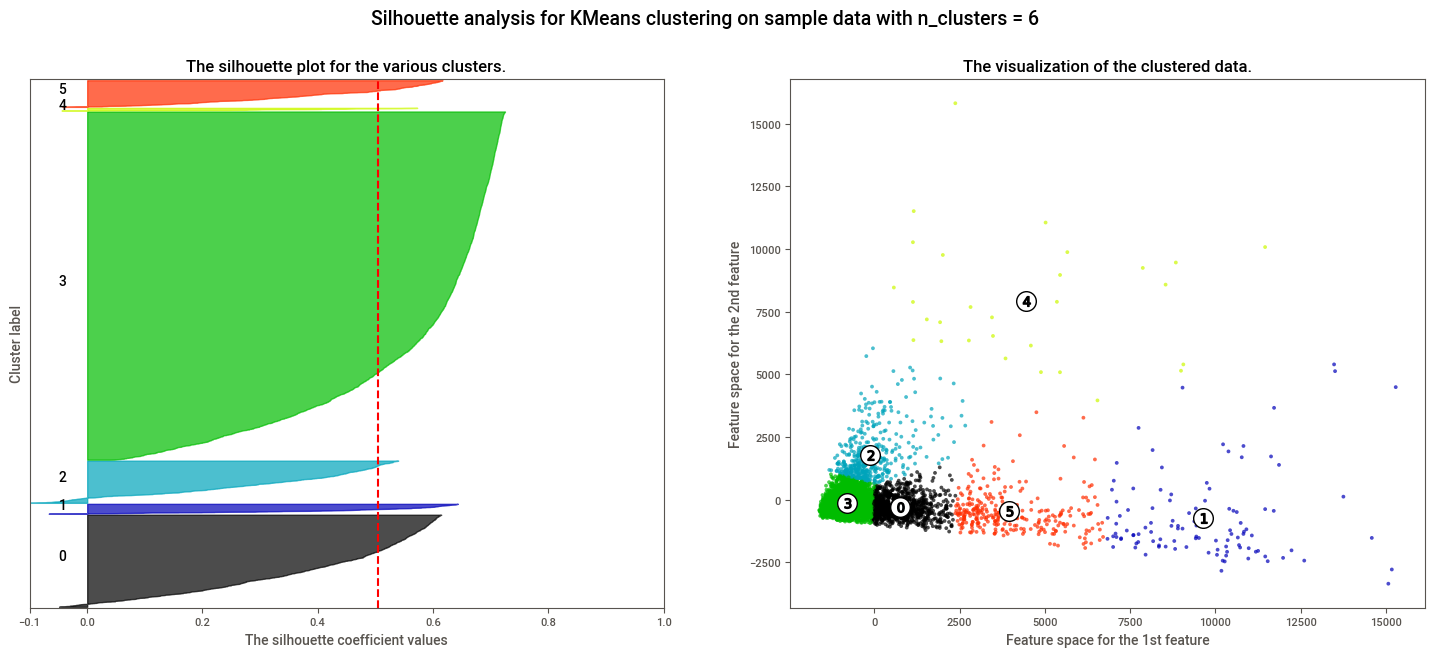

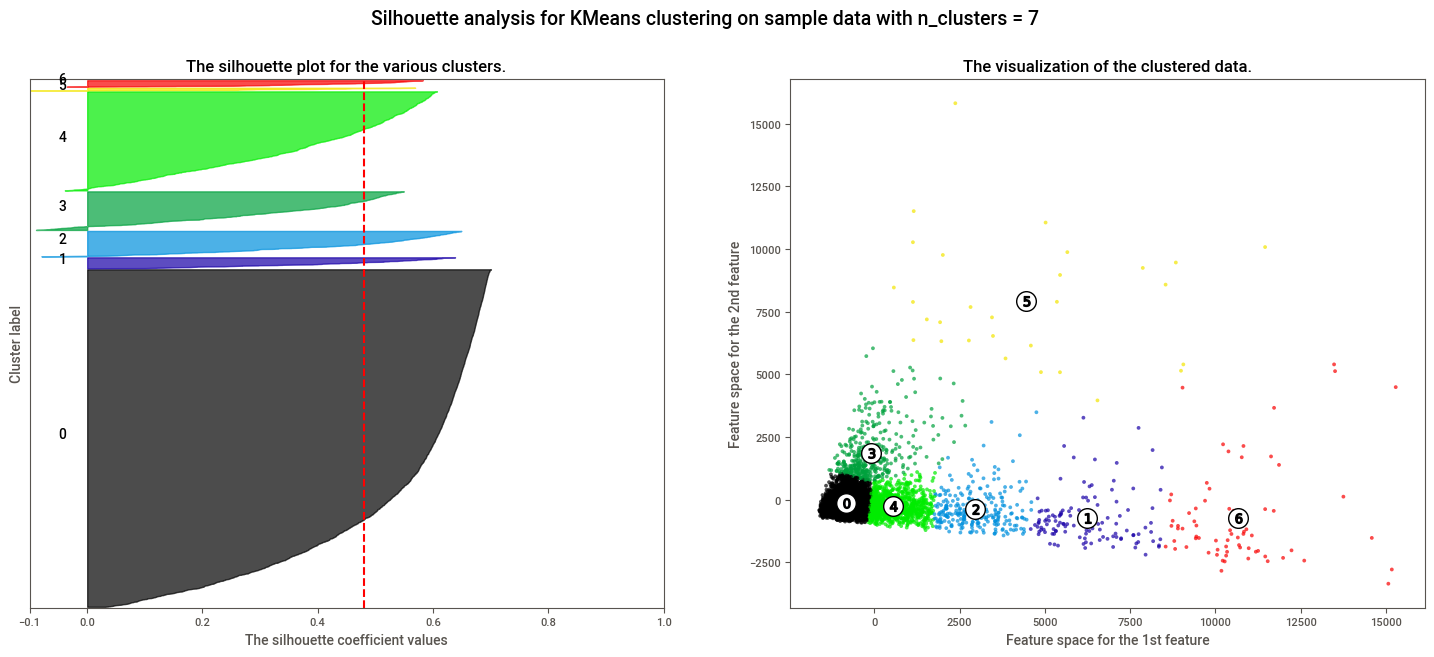

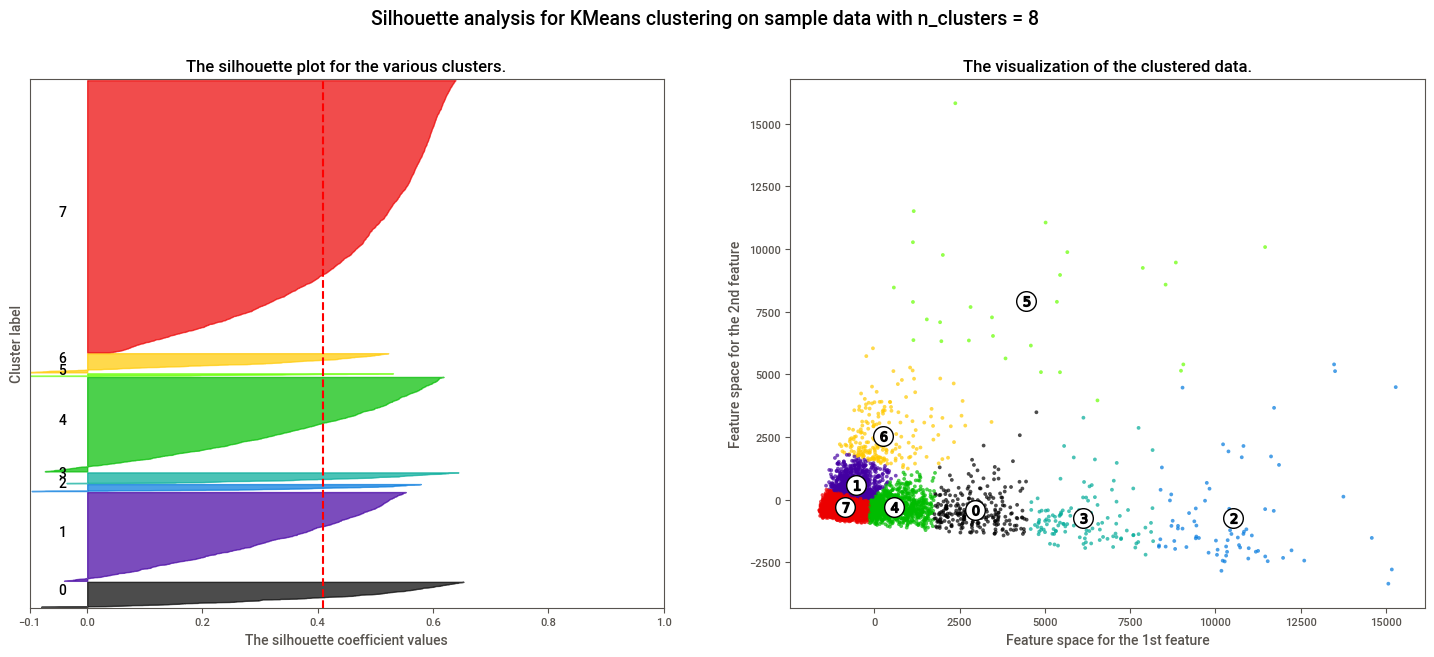

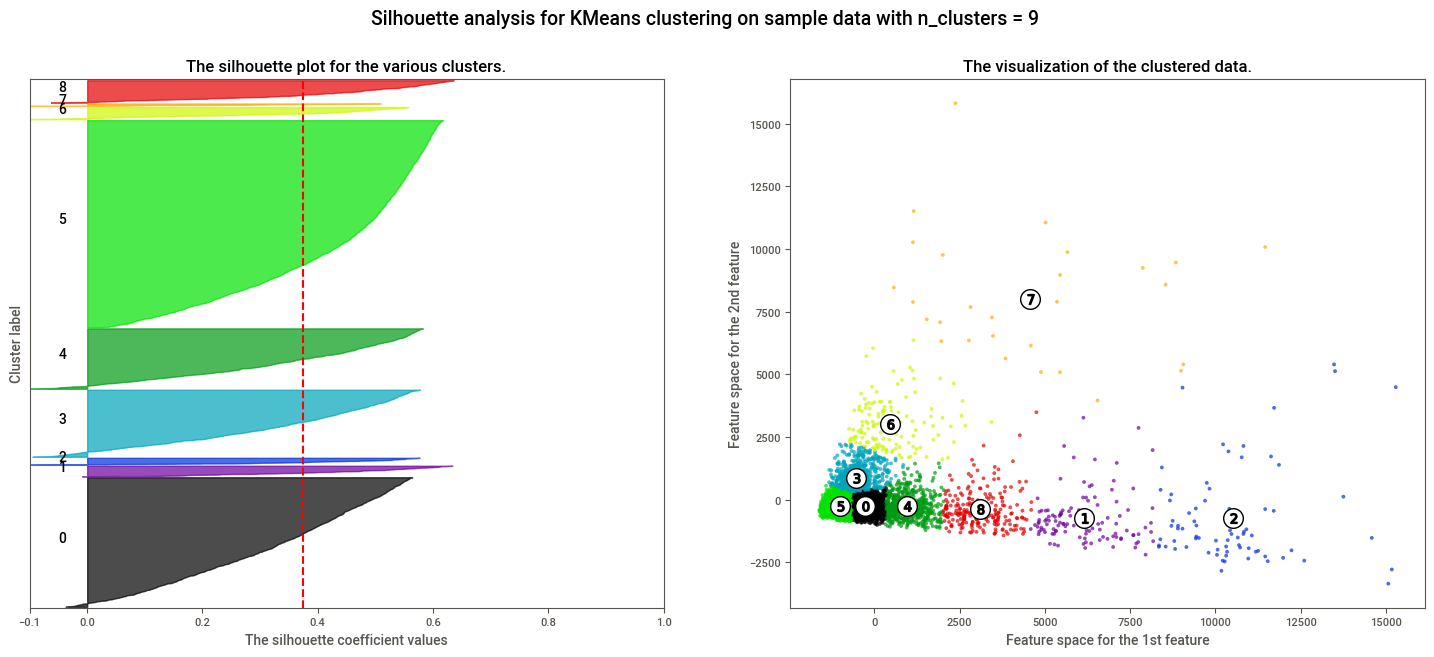

In [248]:
silhoutte_analysis(cluster_data ,KMeans)

> Podemos observar que aplicando el análisis de componentes principales PCA utilizando 3 componentes principales se puede explicar el 99.44 de la varianza de los datos. Esto podría ser un muy buen indicador ya que nos permitiría utilizar los datos filtrados para entrenar nuestros modelos, incluso PCA es una muy buena opción, aunque se pierda información del resto de las componentes.

> Pero podemos notar que al graficar las 3 componentes principales, no somos capaces de ver clústeres de datos. Aplicando KMeans con un análisis de silueta y método del codo de las componentes principales somo capaces de poder generar dos clusteres de datos, que según el score del análisis de silueta es el mejor para nuestro caso. El único inconveniente es que con PCA es difícil de interpretar esta información.


## KMeans

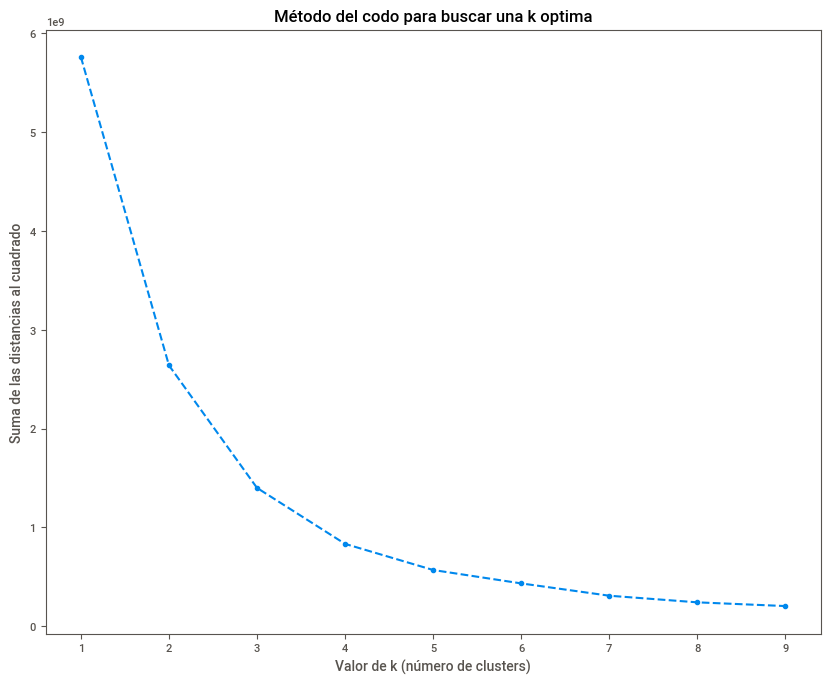

In [249]:
loser_rank_points = df_clustering.loser_rank_points.to_list()
w_calculation = df_clustering.w_calculation.to_list()
w_bpSaved = df_clustering.w_bpSaved.to_list()
cluster_data = list(zip(loser_rank_points, w_calculation , w_bpSaved))

elbow_method(cluster_data, KMeans)


Haciendo un análsisi de la `Suma de las distancias acummuladas` o método del codo, podemos observar que `k = 2` y `k = 3` son buenas opciones, pero cómo podemos verificar cúal es la mejor? Para esto utilizaremos el análisis de silueta que se encuentra en `sklearn`.

### Silhoutte Analysis

[Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#:~:text=Silhouette%20analysis%20can%20be%20used,like%20number%20of%20clusters%20visually)


For n_clusters = 2 The average silhouette_score is : 0.826206504756639
For n_clusters = 3 The average silhouette_score is : 0.7037635949912399
For n_clusters = 4 The average silhouette_score is : 0.5827821854631147
For n_clusters = 5 The average silhouette_score is : 0.5388187789092193
For n_clusters = 6 The average silhouette_score is : 0.5340171895800615
For n_clusters = 7 The average silhouette_score is : 0.487028236475092
For n_clusters = 8 The average silhouette_score is : 0.4744454032155649
For n_clusters = 9 The average silhouette_score is : 0.45391944021459985


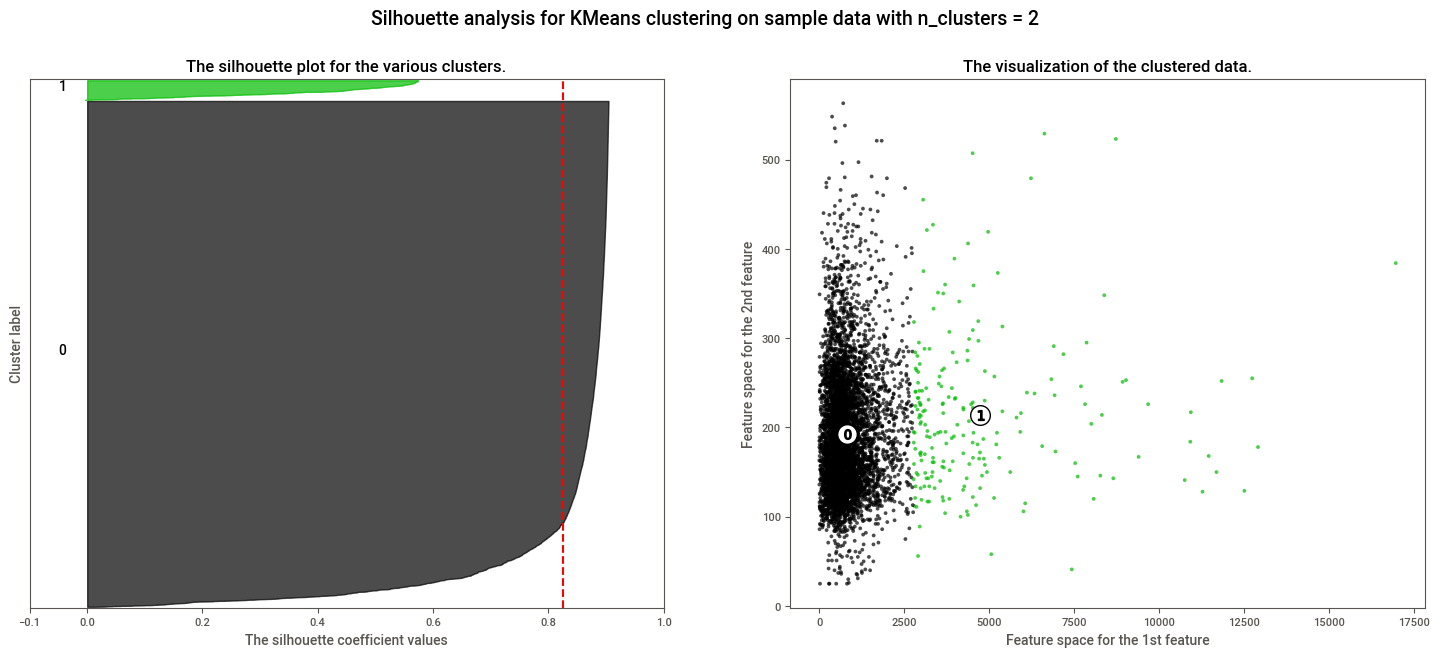

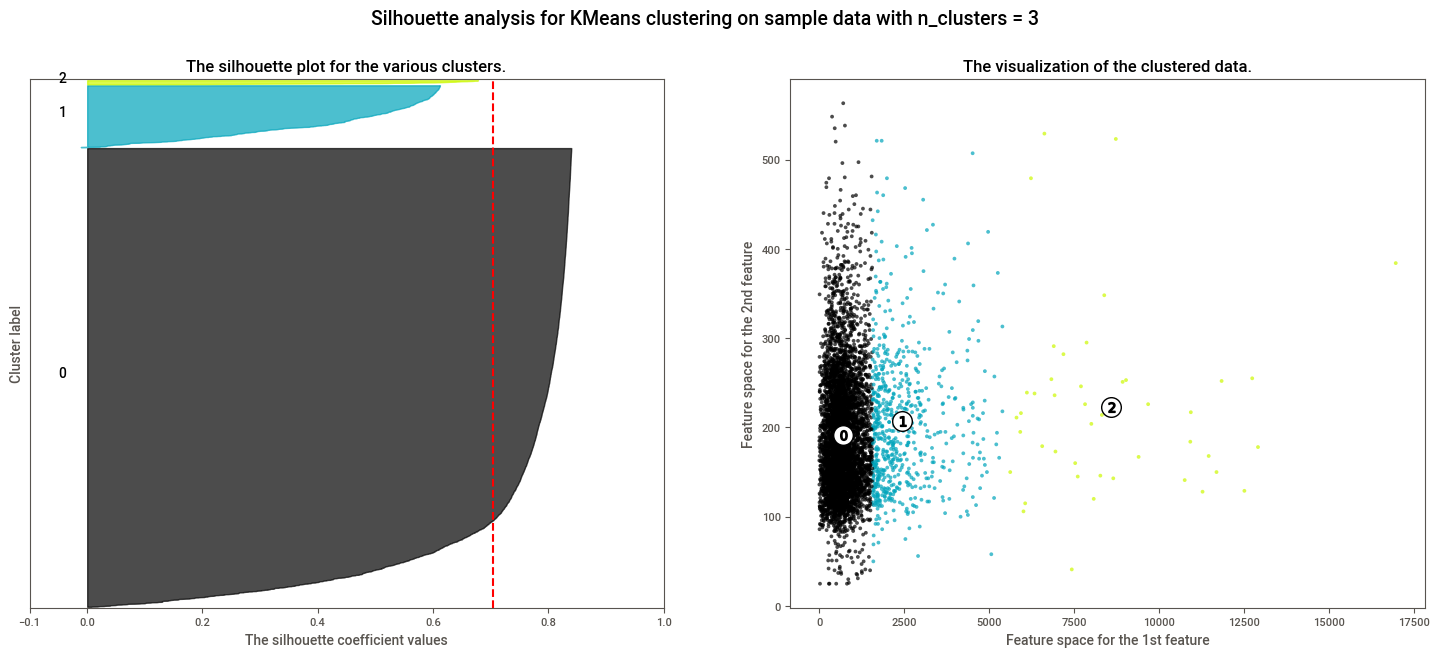

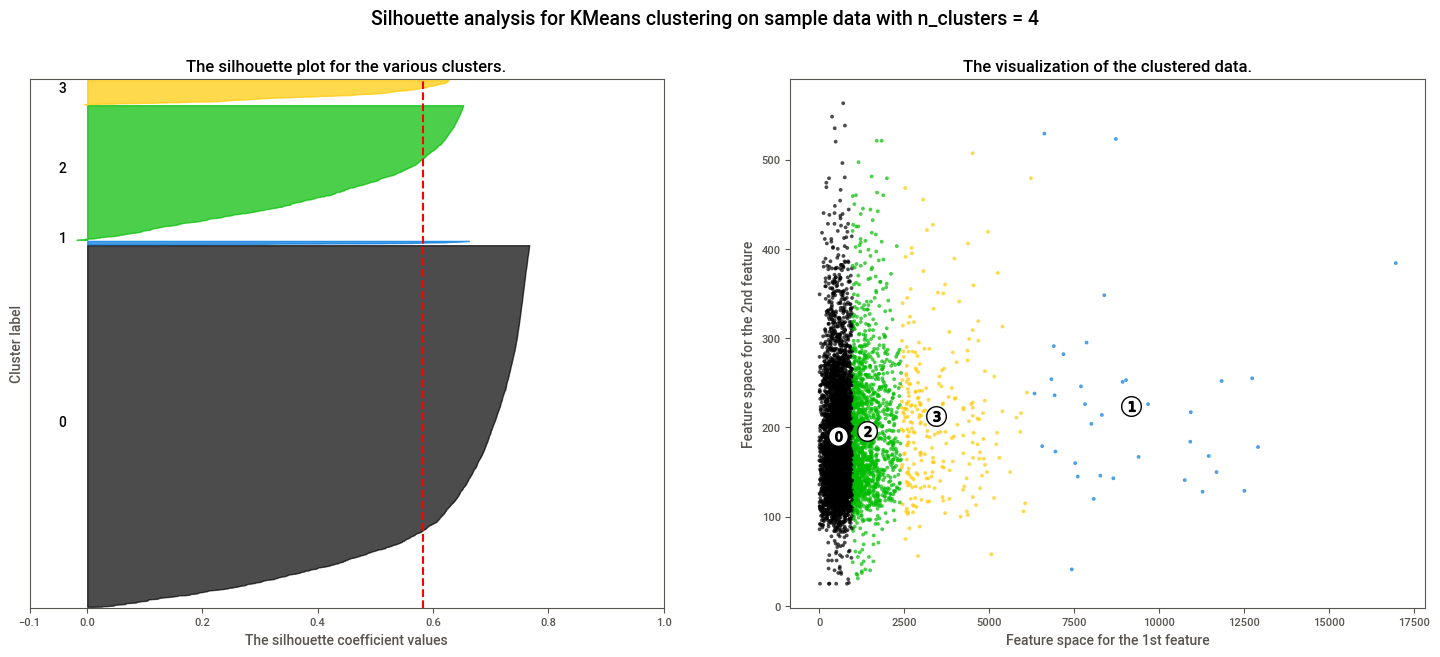

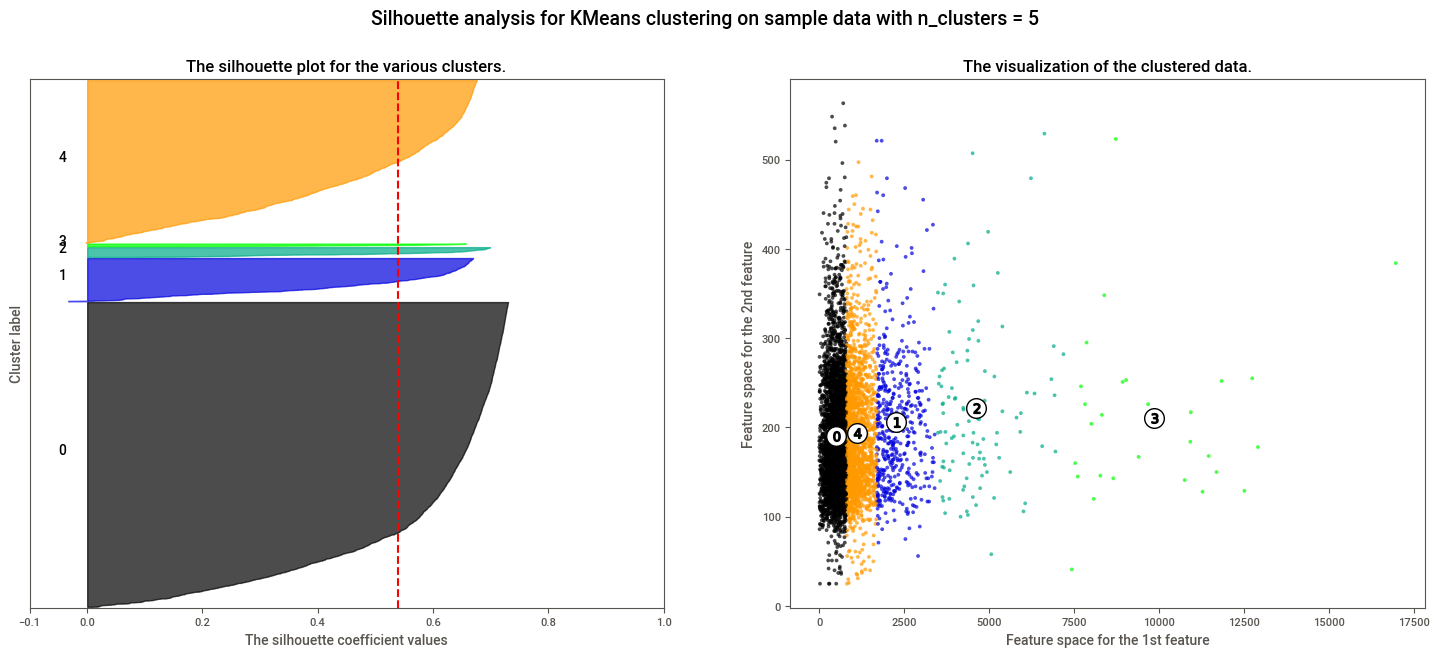

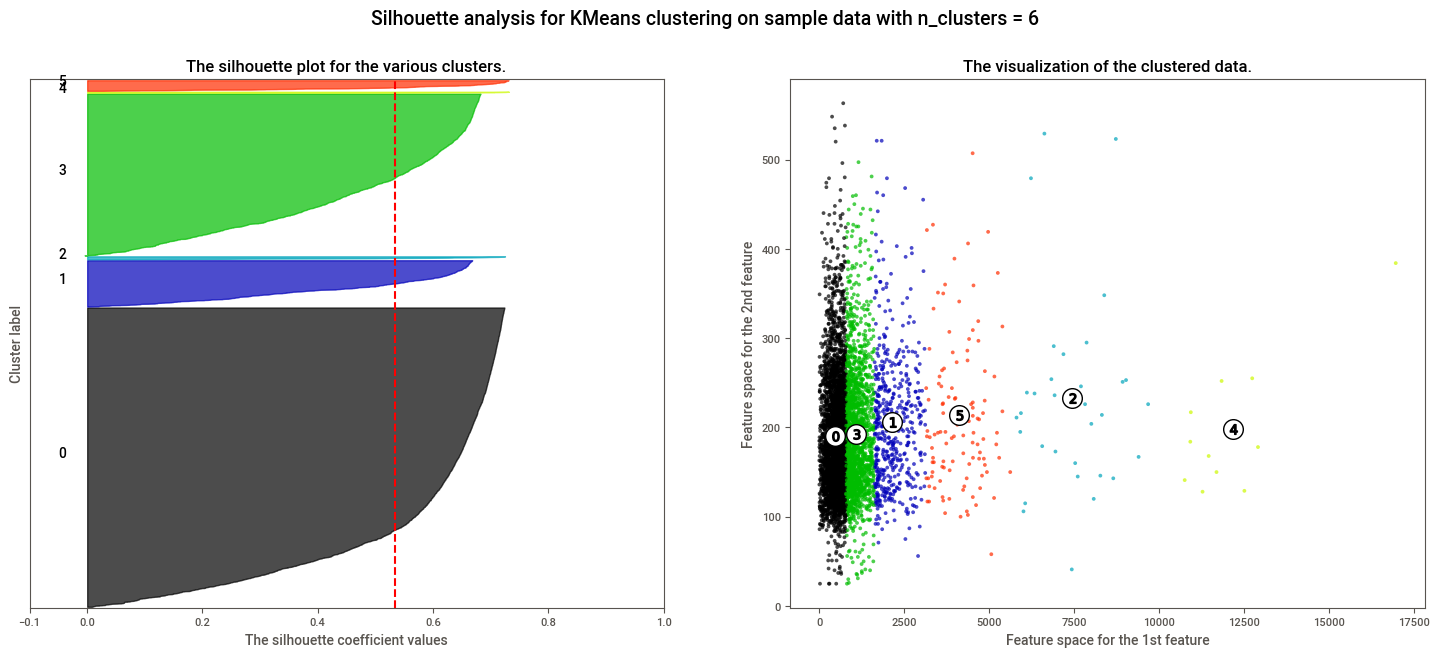

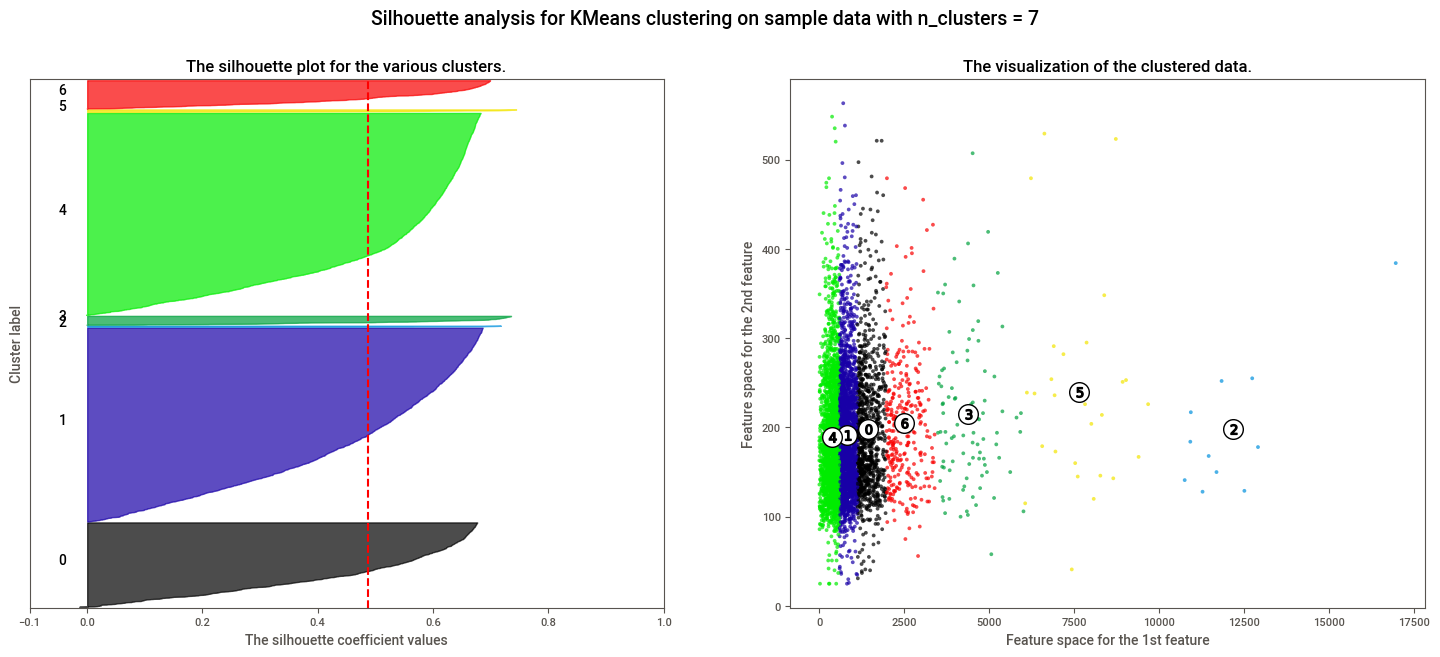

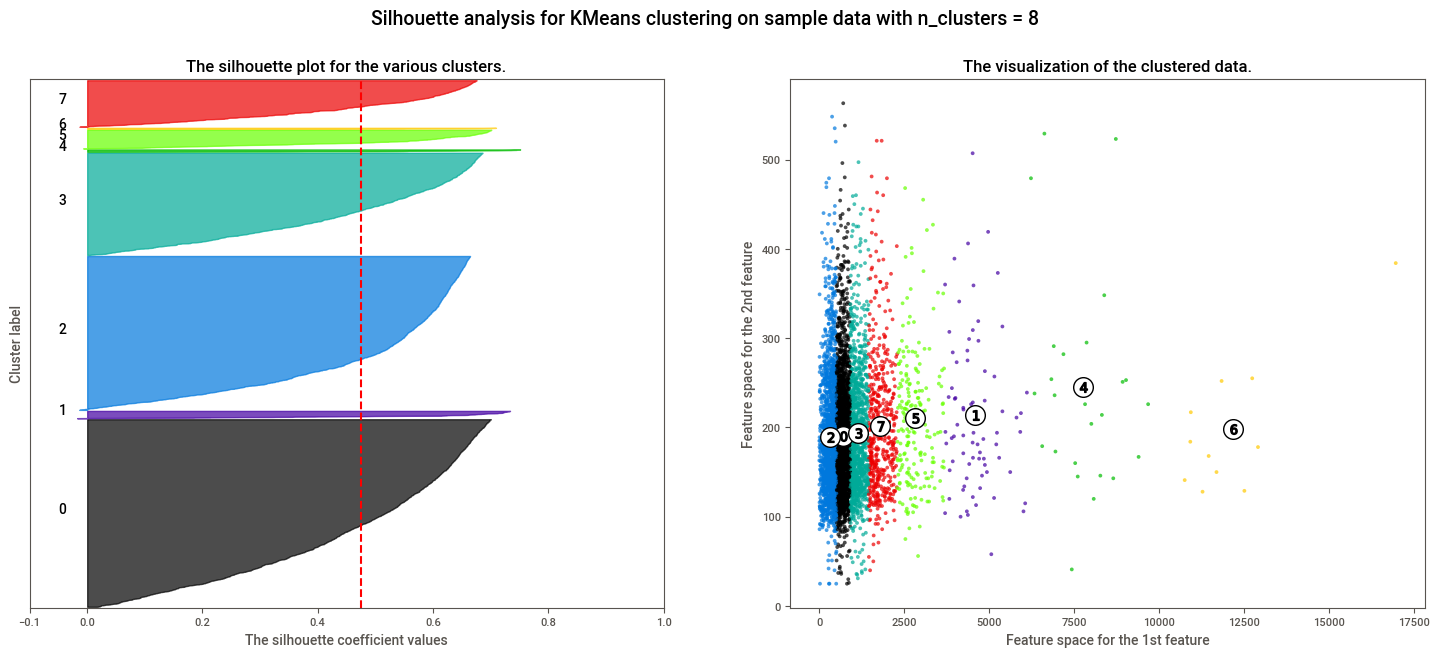

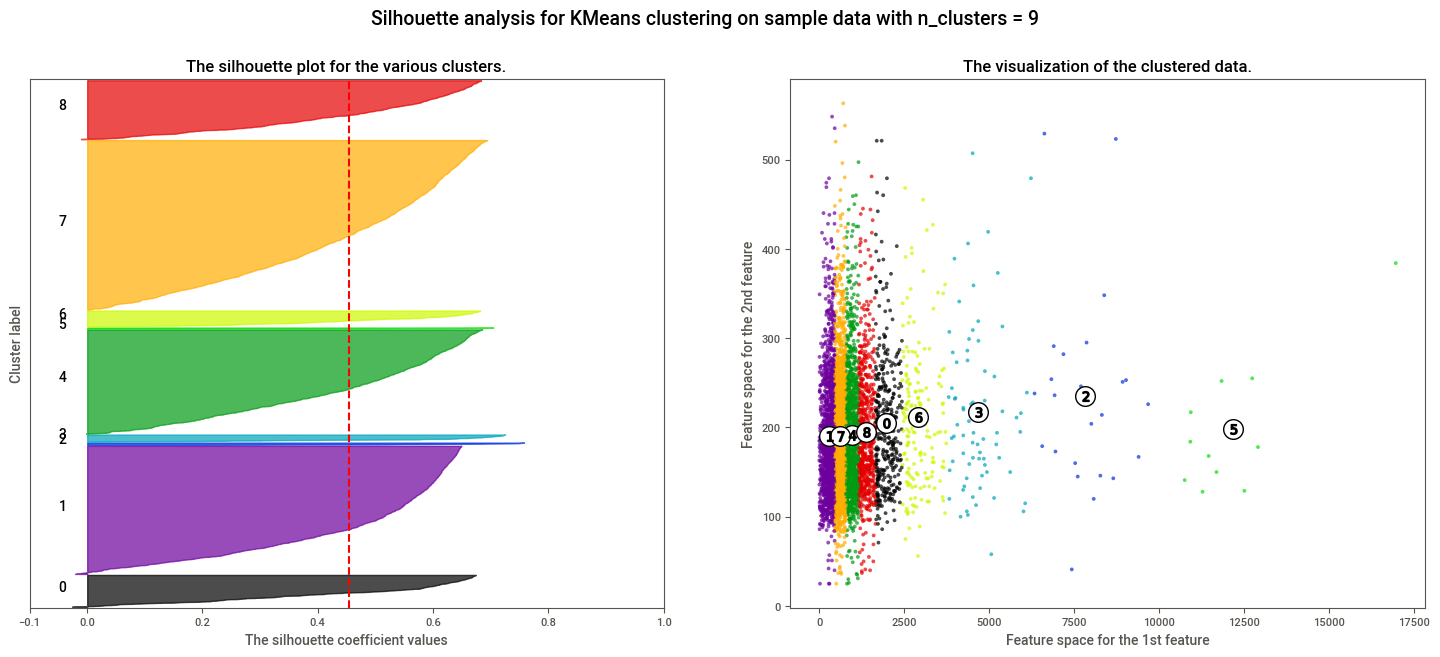

In [250]:
silhoutte_analysis(cluster_data ,KMeans)

Del análisis de silueta del cluster utilizando KMeans, podemos identificar que el mejor score es para `k = 2`, también es una buenas opción `k = 3`.

In [251]:
fig = px.scatter_3d(
    df_clustering, x = 'loser_rank_points', y = 'w_calculation', z = 'w_bpSaved',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(height=800, width=800)
fig.show()

## MiniBatchKMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\c

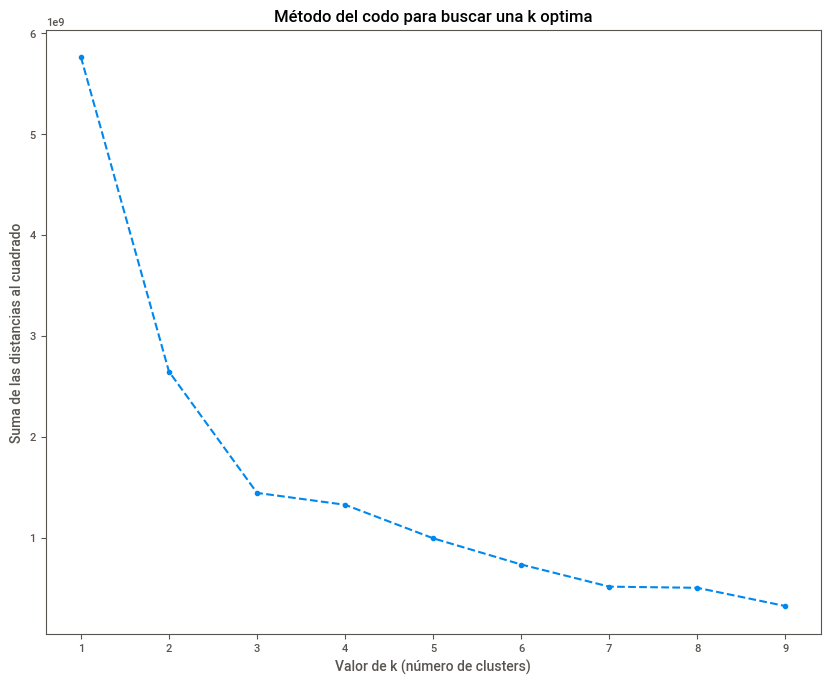

In [252]:
loser_rank_points = df_clustering.loser_rank_points.to_list()
w_calculation = df_clustering.w_calculation.to_list()
w_bpSaved = df_clustering.w_bpSaved.to_list()
cluster_data = list(zip(loser_rank_points, w_calculation , w_bpSaved))

elbow_method(cluster_data, MiniBatchKMeans)

### Silhoutte Analysis

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 2 The average silhouette_score is : 0.6901609084987663


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 3 The average silhouette_score is : 0.6486081925380711


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 4 The average silhouette_score is : 0.4396574209518353


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 5 The average silhouette_score is : 0.5153686838082882


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 6 The average silhouette_score is : 0.41570971418720615


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 7 The average silhouette_score is : 0.4297852927106728


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 8 The average silhouette_score is : 0.4271584800234951


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



For n_clusters = 9 The average silhouette_score is : 0.3988184554930277


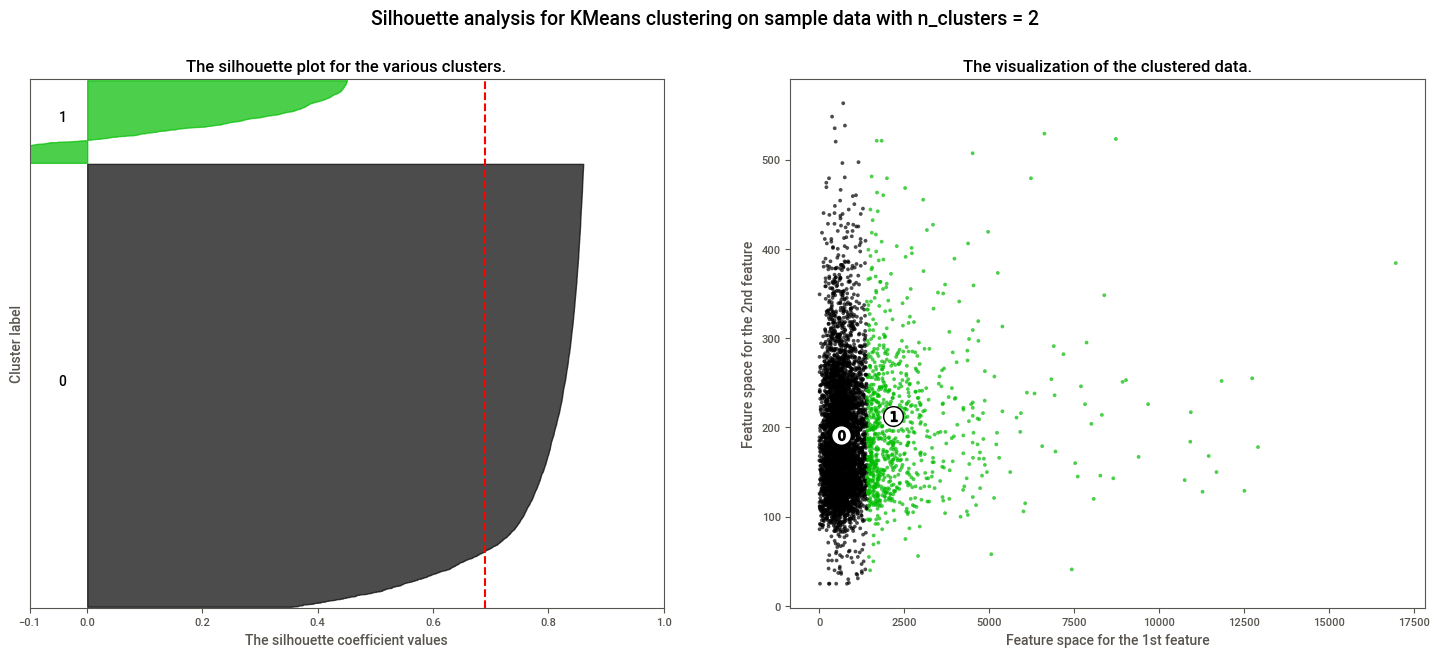

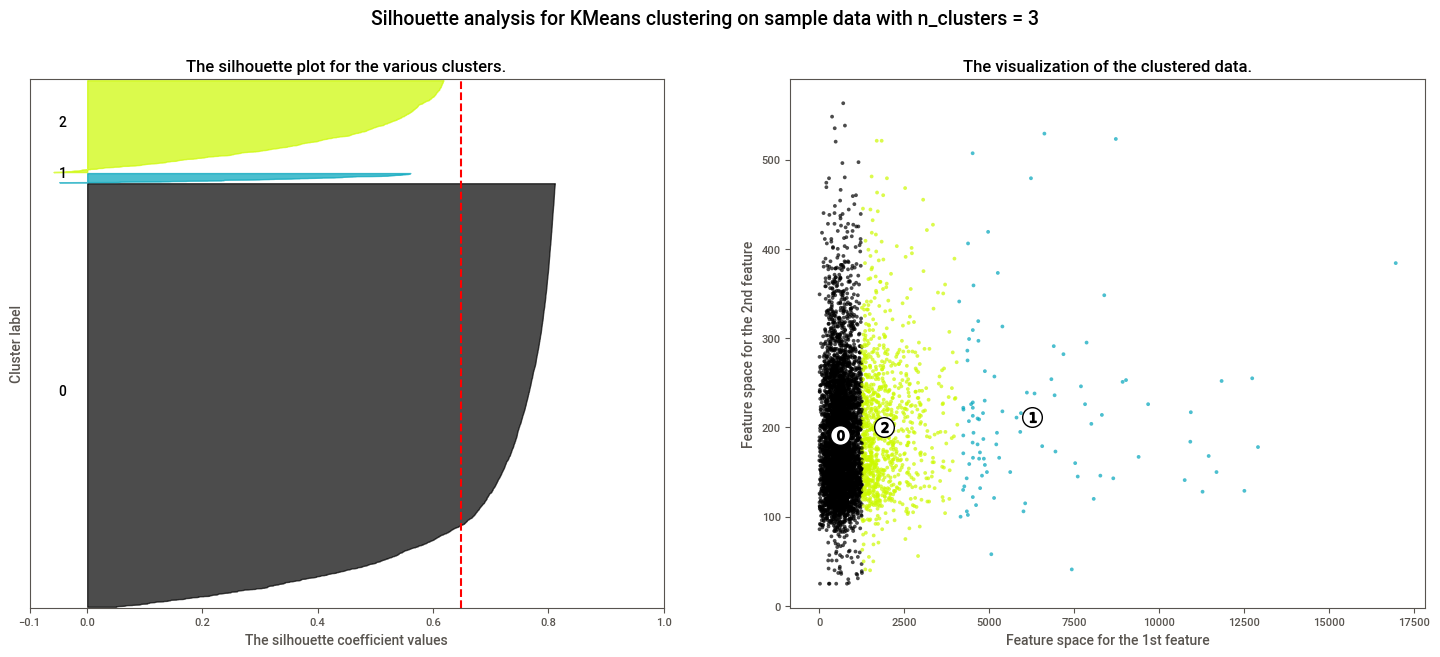

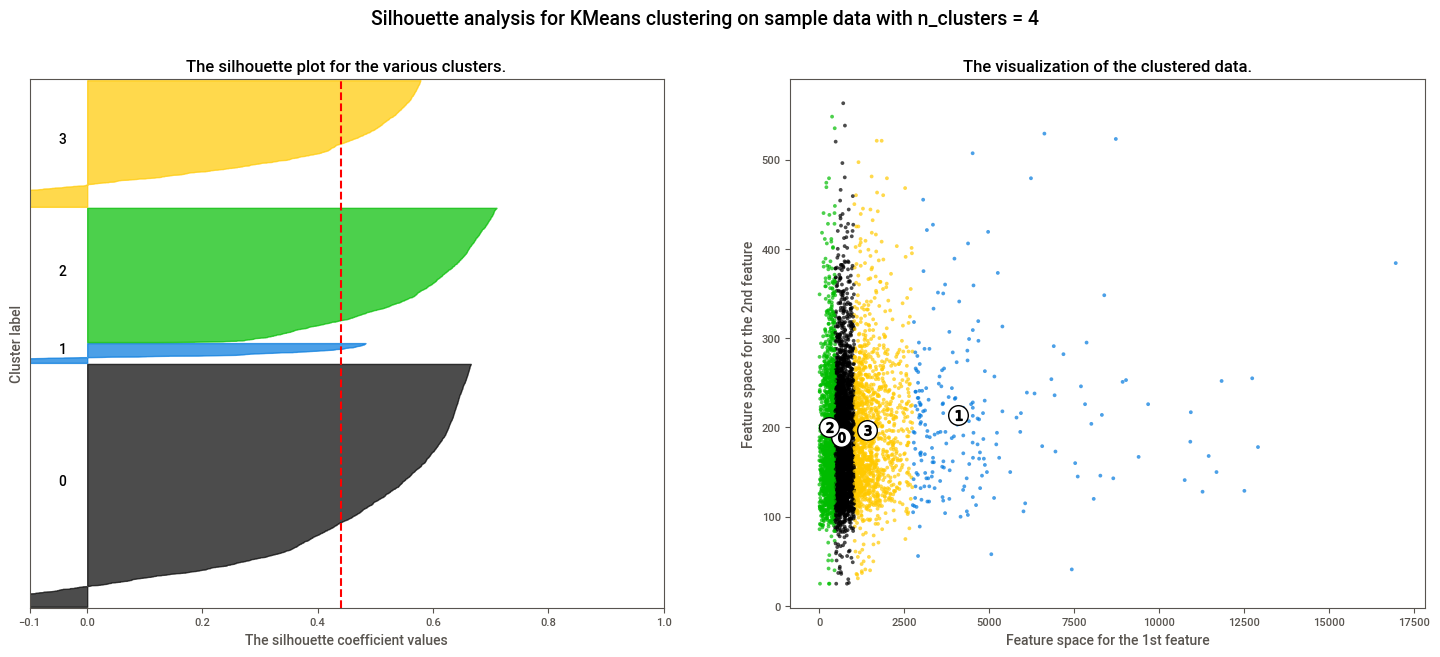

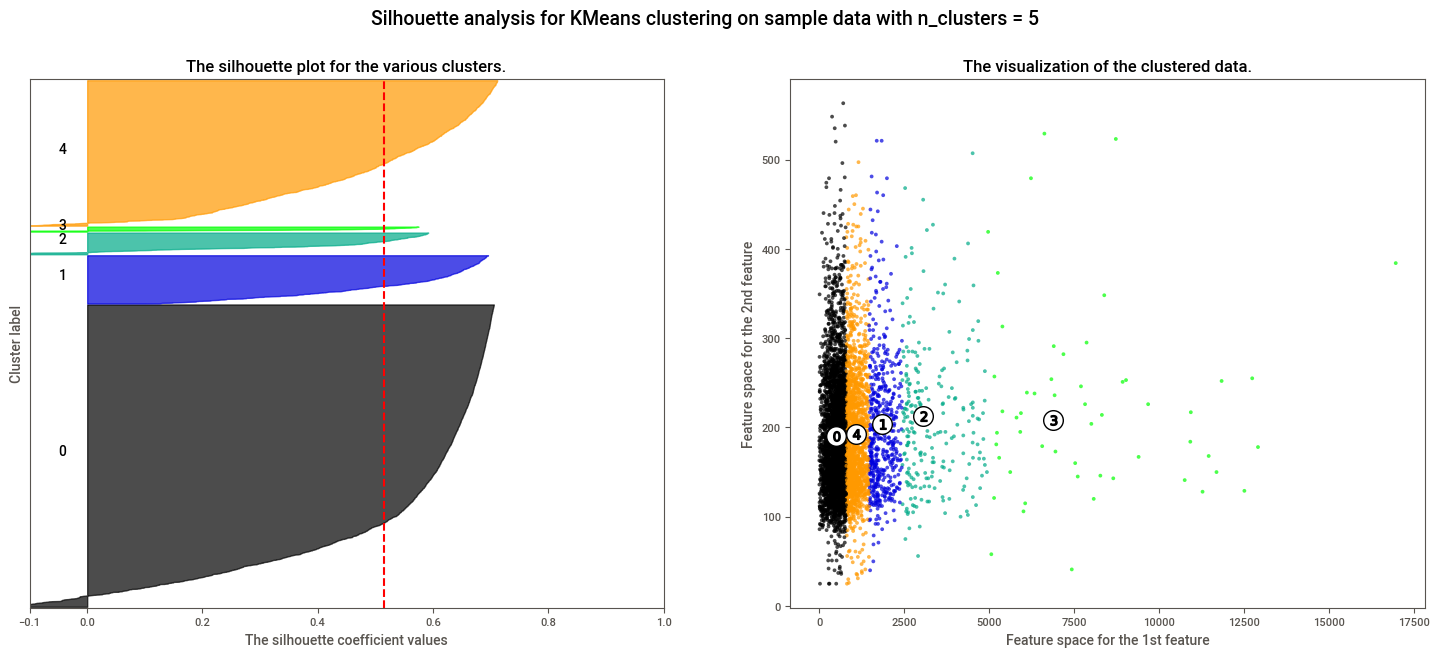

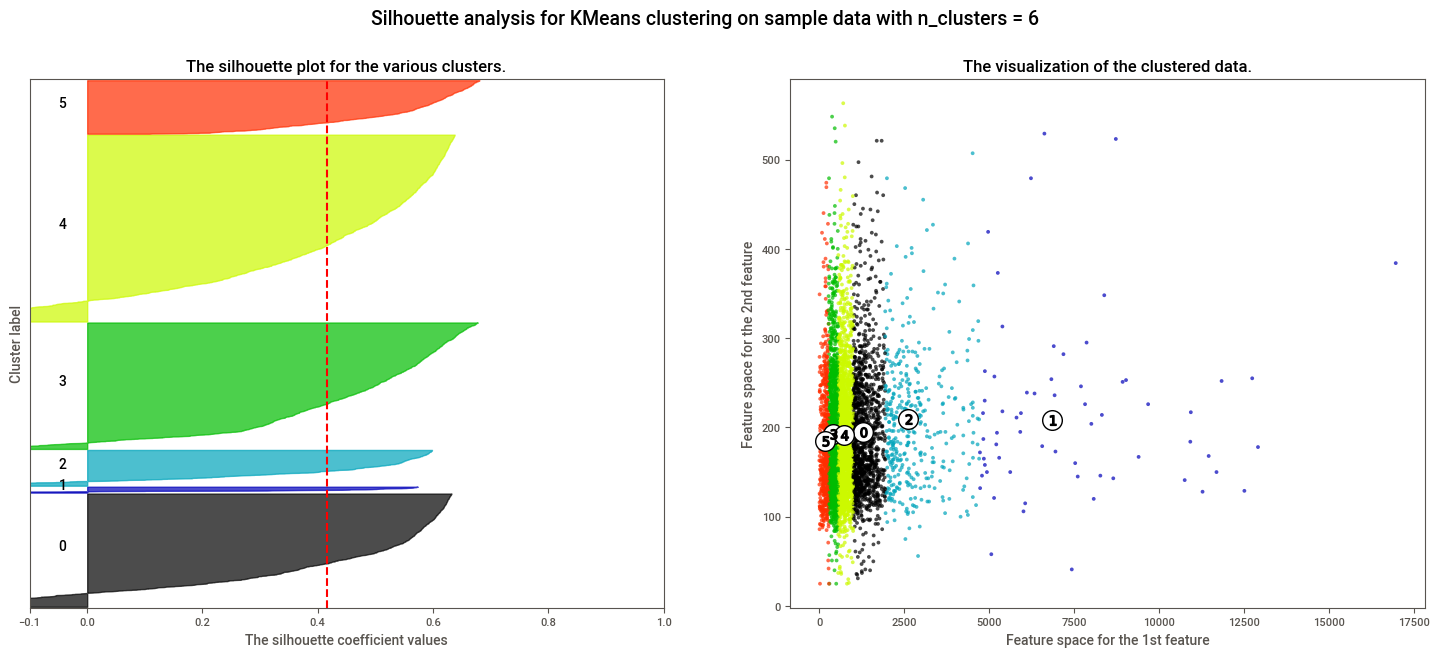

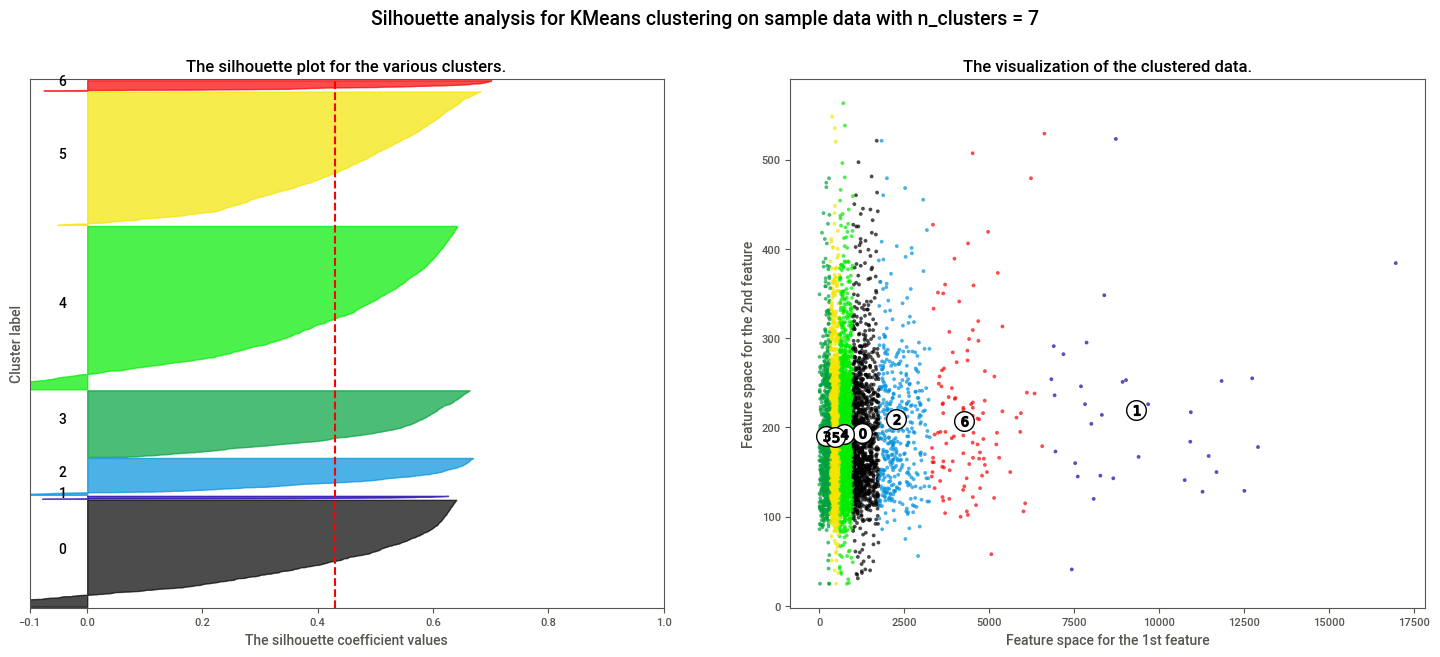

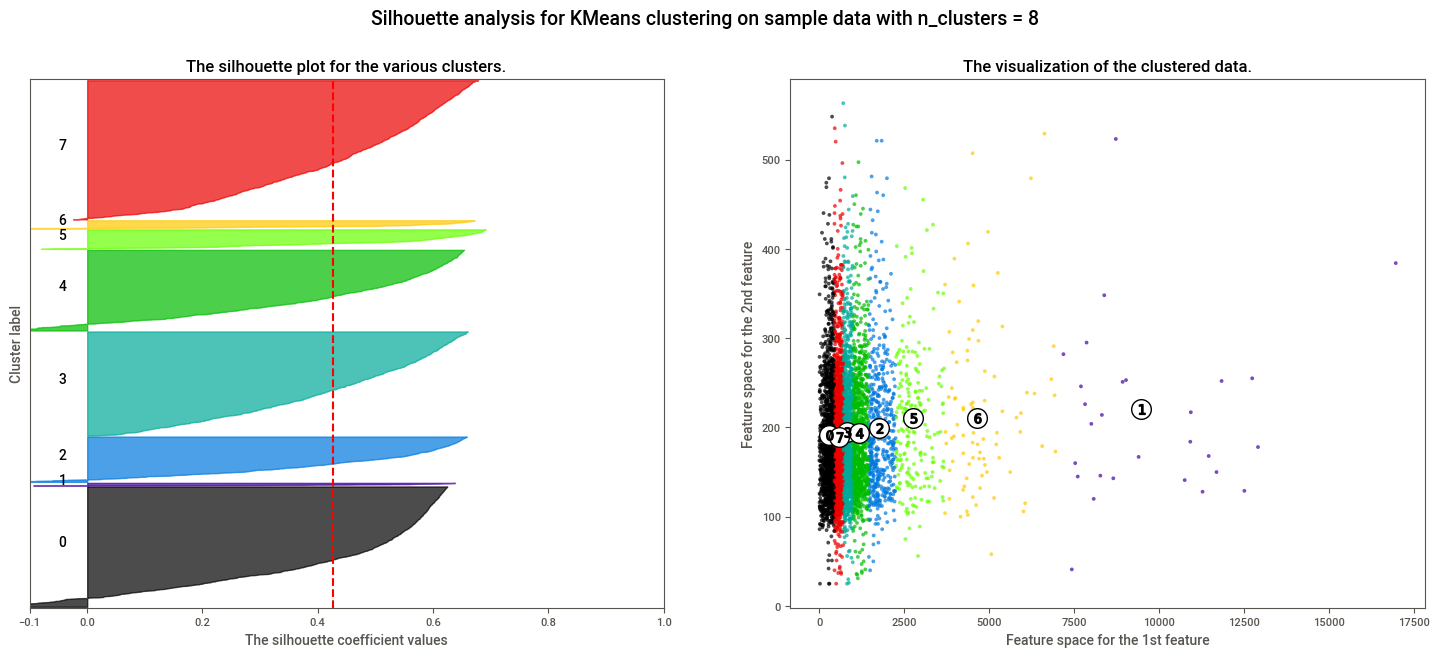

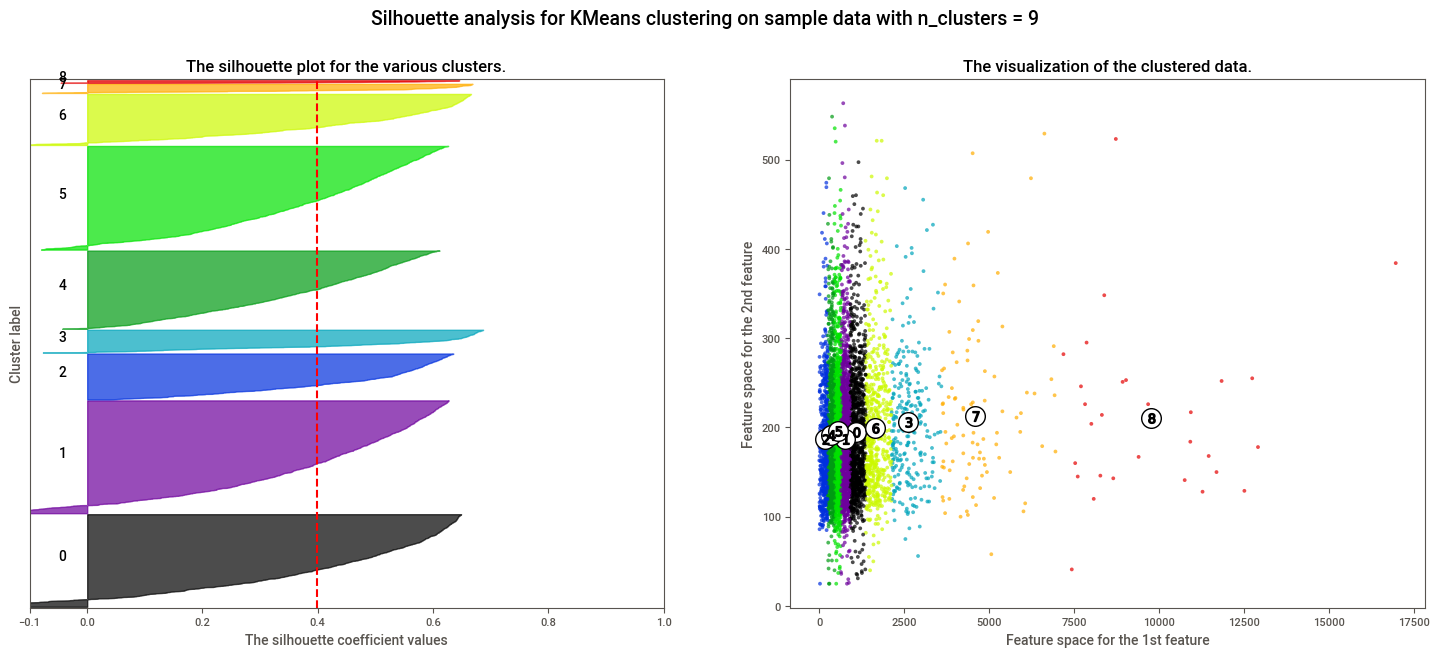

In [253]:
silhoutte_analysis(cluster_data ,MiniBatchKMeans)

## Clustering

> Aquí nos basaremos en [Clustering Tutorial SKLearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py) para poder hacer la representación gráfica le otros métodos de clustering.

In [254]:
loser_rank_points = df_clustering.loser_rank_points.to_list()
w_calculation = df_clustering.w_calculation.to_list()
w_bpSaved = df_clustering.w_bpSaved.to_list()
cluster_data = list(zip(loser_rank_points, w_calculation , w_bpSaved))

In [259]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(cluster_data, quantile=default_base["quantile"])


# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    cluster_data, n_neighbors=default_base["n_neighbors"], include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)


ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = MiniBatchKMeans(n_clusters=default_base["n_clusters"])
ward = AgglomerativeClustering(
    n_clusters=default_base["n_clusters"], linkage="ward", connectivity=connectivity
)
spectral = SpectralClustering(
    n_clusters=default_base["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
)
dbscan = DBSCAN(eps=default_base["eps"])
optics = OPTICS(
    min_samples=default_base["min_samples"],
    xi=default_base["xi"],
    min_cluster_size=default_base["min_cluster_size"],
)
affinity_propagation = AffinityPropagation(
    damping=default_base["damping"], preference=default_base["preference"], random_state=0
)
average_linkage = AgglomerativeClustering(
    linkage="average",
    affinity="cityblock",
    n_clusters=default_base["n_clusters"],
    connectivity=connectivity,
)
birch = Birch(n_clusters=default_base["n_clusters"])
gmm = GaussianMixture(
    n_components=default_base["n_clusters"], covariance_type="full"
)
clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("Affinity\nPropagation", affinity_propagation),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("DBSCAN", dbscan),
    ("OPTICS", optics),
    ("BIRCH", birch),
)



In [260]:
df_cluster_data = pd.DataFrame(cluster_data)
for name, algorithm in clustering_algorithms:
    
    start = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(int)

    else:
        y_pred = algorithm.fit_predict(cluster_data)
    end = time.time()
    
    
    df = pd.DataFrame()
    df['loser_rank_points'] = df_cluster_data[[0]]
    df['w_calculation'] = df_cluster_data[[1]]
    df['w_bpSaved'] = df_cluster_data[[2]]
    df['pred'] = y_pred
    df = df.sort_values(by=['pred'])
    df["pred"] = df["pred"].astype(str)

    ellapsed_time = round(end - start, 2)
    
    fig = px.scatter_3d(df, x='loser_rank_points', y='w_calculation', z='w_bpSaved', color='pred', labels={"pred": "Clusters"})
    fig.update_layout(height=800, width=800)
    fig.update_layout(title = name + ', Elapsed Time:' +str(ellapsed_time)+ ' (s)')

    fig.show() 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



## Conclusions

- `Minibatch KMeans` es uno de los métodos de clustering que no logra separa los grupos correctamente, podemos observar que los datos se encuentran mezclados entre sí.

- `Affinity Propagation` Es uno de los métodos que en este caso no logra encontrar los clusters dentro de los datos. Este método es uno de los métodos que más demora en encontrar los clusters.

# Bibliografía

https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086

https://pythonprogramming.net/mean-shift-titanic-dataset-machine-learning-tutorial/?completed=/hierarchical-clustering-mean-shift-machine-learning-tutorial/


